In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from collections import Counter

#Model import
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.manifold import TSNE

#하이퍼파라미터 튜닝
import optuna

## EDA

In [5]:
#Data load
base_path = '../data/'
train = pd.read_csv(base_path + 'train.csv', index_col= 'id')
test = pd.read_csv(base_path + 'test.csv', index_col= 'id')

In [21]:
#Not null
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101763 entries, 0 to 101762
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loc                101763 non-null  float64
 1   v(g)               101763 non-null  float64
 2   ev(g)              101763 non-null  float64
 3   iv(g)              101763 non-null  float64
 4   n                  101763 non-null  float64
 5   v                  101763 non-null  float64
 6   l                  101763 non-null  float64
 7   d                  101763 non-null  float64
 8   i                  101763 non-null  float64
 9   e                  101763 non-null  float64
 10  b                  101763 non-null  float64
 11  t                  101763 non-null  float64
 12  lOCode             101763 non-null  int64  
 13  lOComment          101763 non-null  int64  
 14  lOBlank            101763 non-null  int64  
 15  locCodeAndComment  101763 non-null  int64  
 16  un

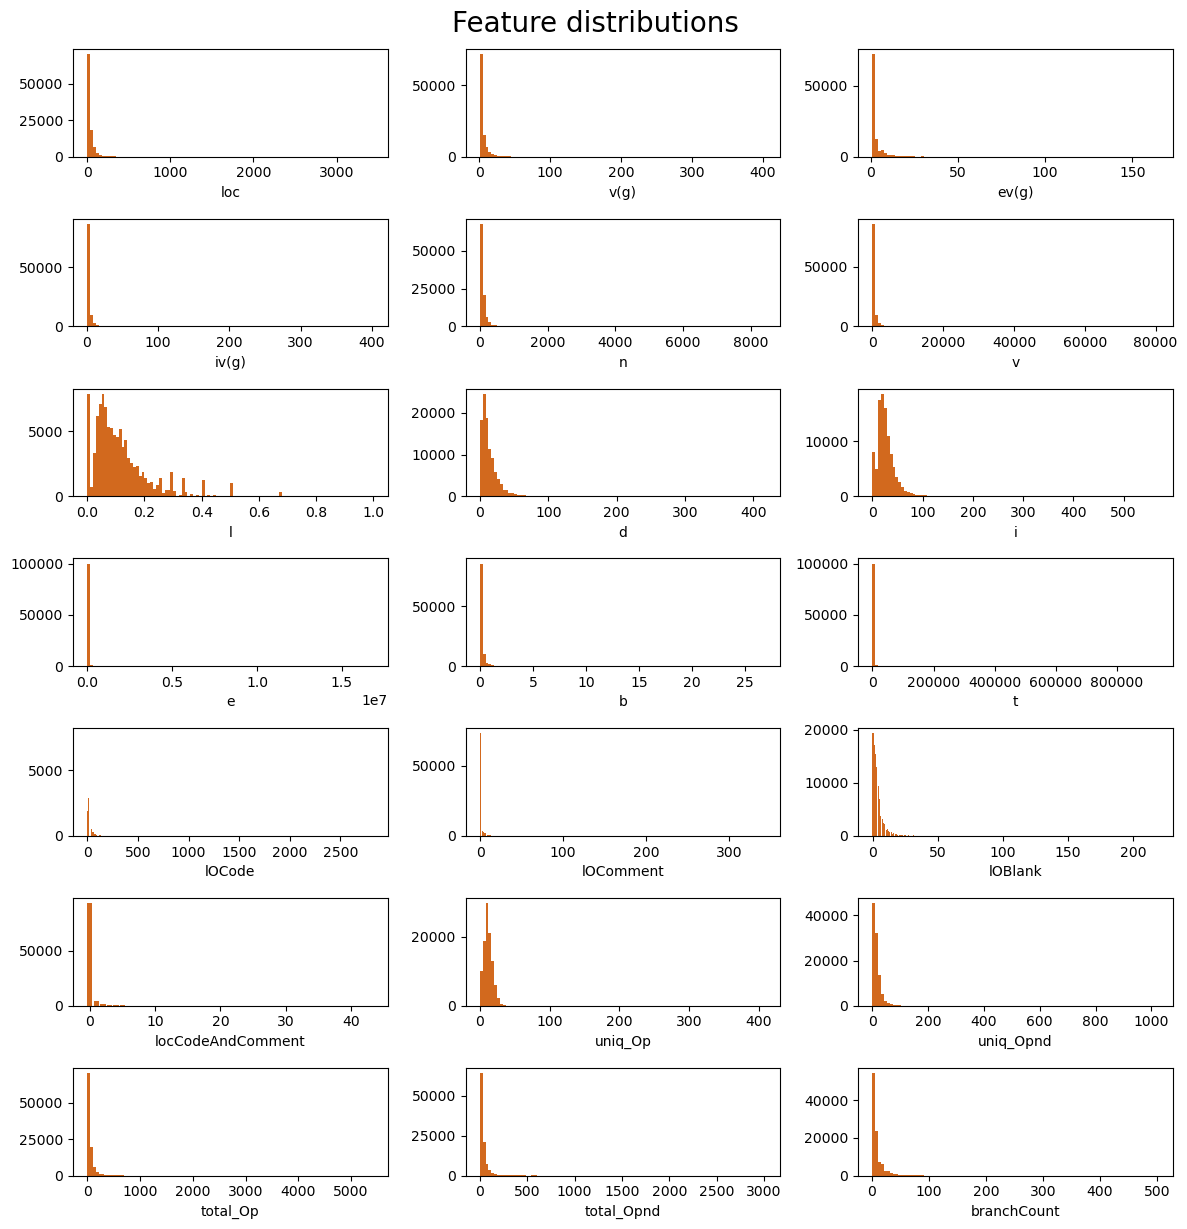

In [12]:
_, axs = plt.subplots(7, 3, figsize=(12, 12))
for col, ax in zip(test.columns, axs.ravel()):
    if train[col].dtype == float:
        ax.hist(train[col], bins=100, color='chocolate')
    else: #int
        vc = train[col].value_counts()
        ax.bar(vc.index, vc, color='chocolate')
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

#### 오른쪽으로 치우쳐져있기 때문에 log-transform 변환 시도

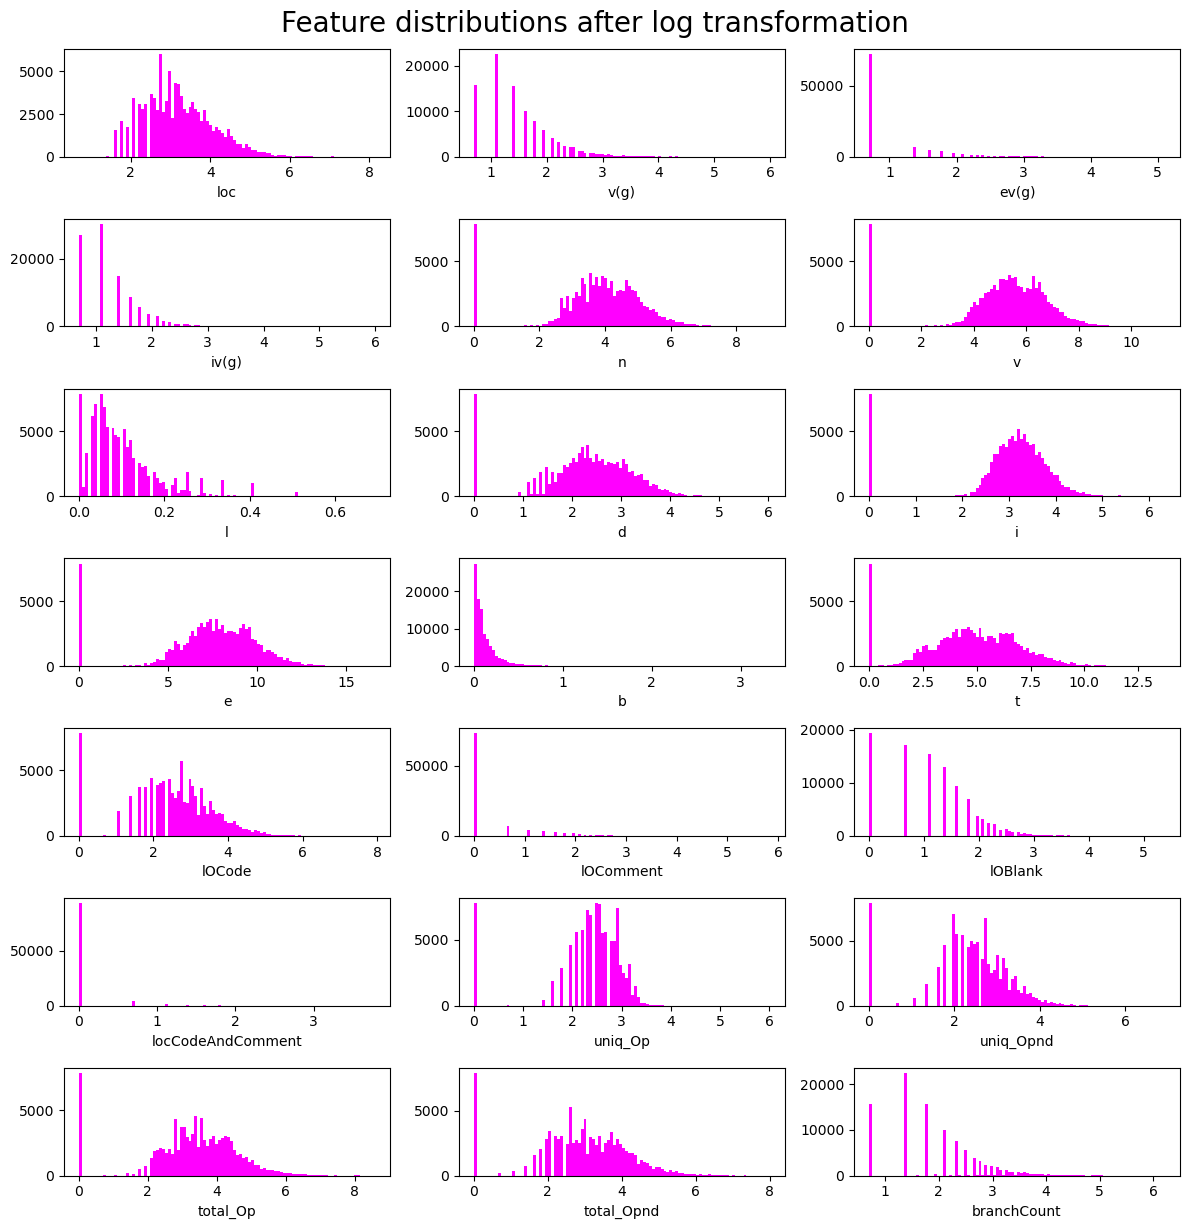

In [7]:
_, axs = plt.subplots(7, 3, figsize=(12, 12))
for col, ax in zip(test.columns, axs.ravel()):
    ax.hist(np.log1p(train[col]), bins=100, color='magenta')
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Feature distributions after log transformation', y=1.02, fontsize=20)
plt.show()

Text(0.5, 1.0, 'Correlations Among Input Features')

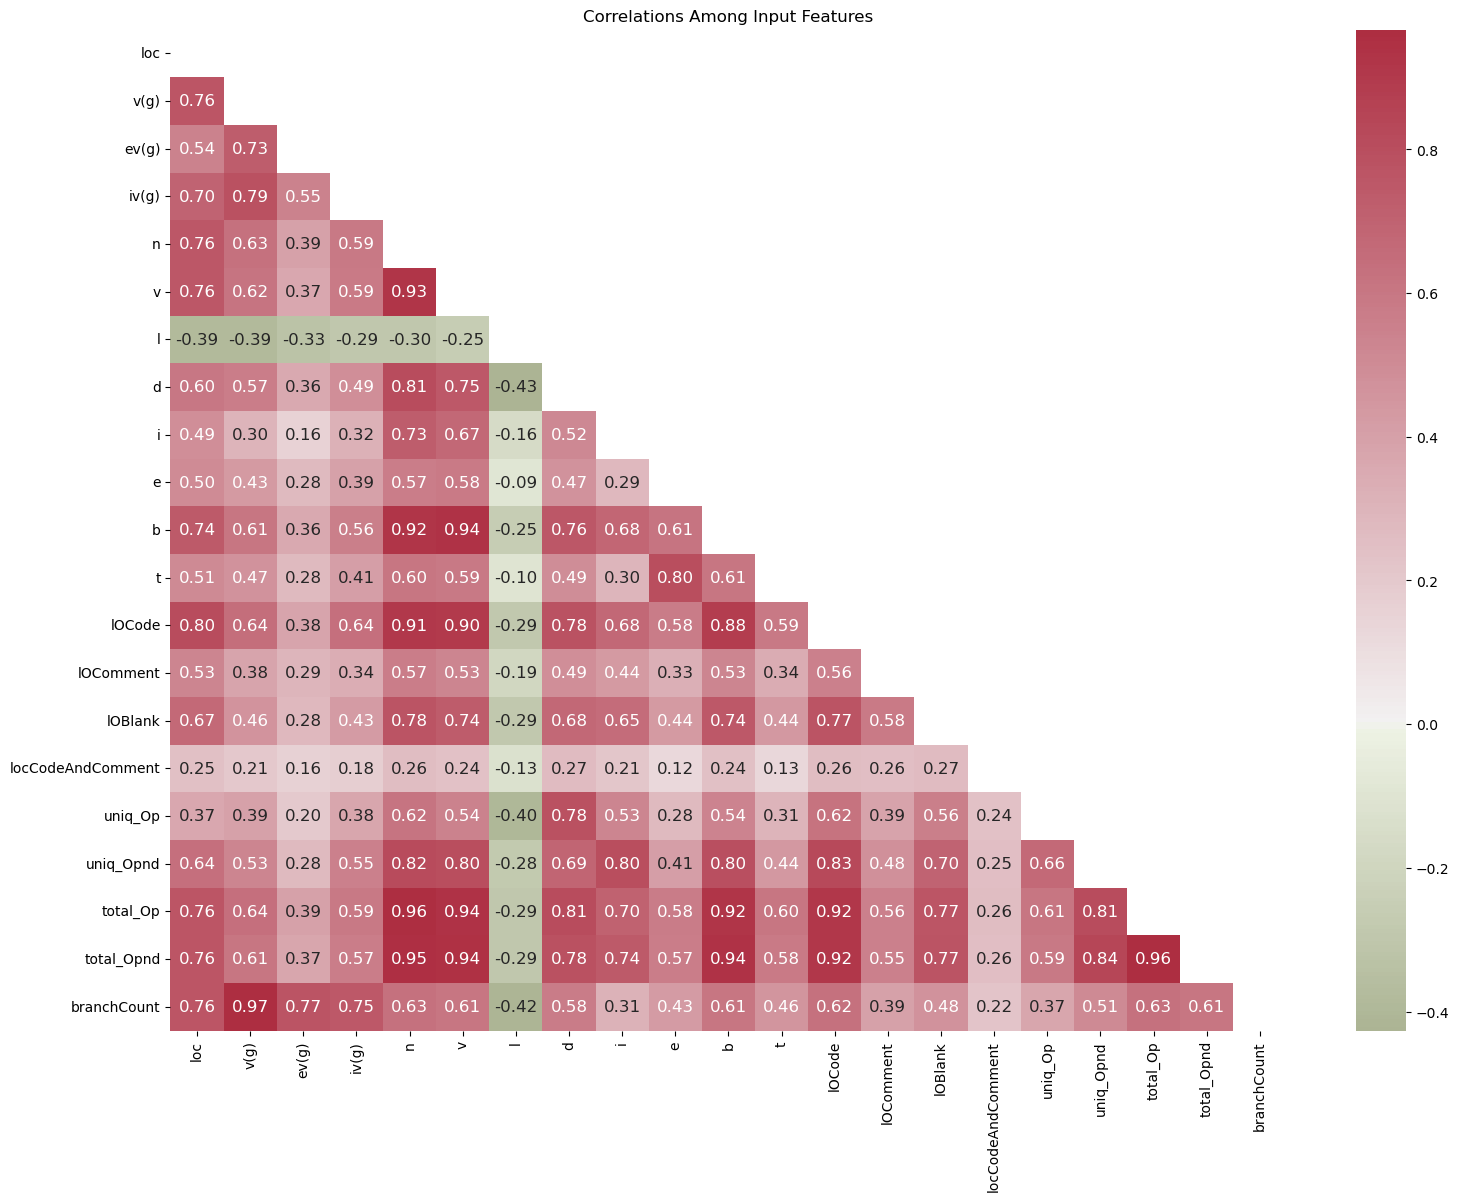

In [19]:
corr_mat = train.drop(columns = ['defects'], axis = 1).corr()
data_mask = np.triu(np.ones_like(corr_mat, dtype = bool))
cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 20, center = 'light', as_cmap = True)
f, ax = plt.subplots(figsize = (18, 13))
sns.heatmap(corr_mat, annot = True, cmap = cmap, fmt = '.2f', center = 0,
            annot_kws = {'size': 12}, mask = data_mask).set_title('Correlations Among Input Features')

## Cross Val code 1

In [ ]:
def cross_val(model, label):
    """Cross-validate the model with a StratifiedKFold
    
    The cross-validation score is printed and added to the global result_list"""
    start_time = datetime.now()
    kf = StratifiedKFold(shuffle=True, random_state=1)
    oof = np.full(len(train), np.nan)
    auc_list = []
    for fold, (idx_tr, idx_va) in enumerate(kf.split(train, train.defects)):
        X_tr = train.iloc[idx_tr]
        X_va = train.iloc[idx_va]
        y_tr = X_tr.pop('defects')
        y_va = X_va.pop('defects')
        model.fit(X_tr, y_tr)
#         print(np.round(model[-1].coef_, 2), np.round(model[-1].intercept_, 2))
        try:
            y_va_pred = model.predict_proba(X_va)[:, 1]
        except AttributeError: # 'LinearSVC' object has no attribute 'predict_proba'
            y_va_pred = model.decision_function(X_va)
        oof[idx_va] = y_va_pred
        auc = roc_auc_score(y_va, y_va_pred)
        auc_list.append(auc)
    auc = np.array(auc_list).mean()
    execution_time = datetime.now() - start_time
    print(f"# AUC {auc:.5f}   time={str(execution_time)[-15:-7]}   {label}")
    result_list.append((auc, label, execution_time))
#     plt.figure(figsize=(6, 2))
#     plt.hist(oof, bins=200, density=True)
#     plt.show()
    return auc

def plot_score_list(label, parameter, xscale='linear'):
    """Show a scatterplot of the scores in the global variable score_list"""
    plt.figure(figsize=(6, 3))
    plt.scatter([p for p, s in score_list],
                [s for p, s in score_list])
    plt.xscale(xscale)
    plt.xlabel(f'{parameter}{" (log-scale)" if xscale == "log" else ""}')
    plt.ylabel('AUC score')
    plt.title(label)
    plt.show()

# RandomForestClassifier
score_list = []
for min_samples_leaf in [100, 150, 200, 250, 300]:
    auc = cross_val(RandomForestClassifier(n_estimators=100,
                                           min_samples_leaf=min_samples_leaf,
                                           max_features=1.0,
                                           random_state=1),
                    f"RF {min_samples_leaf=}")
    score_list.append((min_samples_leaf, auc))
plot_score_list('RandomForestClassifier', 'min_samples_leaf')

# AUC 0.78969   time=0:05:33   RF min_samples_leaf=50
# AUC 0.79057   time=0:04:50   RF min_samples_leaf=100
# AUC 0.79104   time=0:04:12   RF min_samples_leaf=200
# AUC 0.79074   time=0:03:43   RF min_samples_leaf=300
# AUC 0.79058   time=0:03:29   RF min_samples_leaf=400

## 데이터 load & Split

In [6]:
base_path = '../data/'
train = pd.read_csv(base_path + 'train.csv')
test = pd.read_csv(base_path + 'test.csv').drop(columns = ['id'], axis = 1).apply(lambda x: np.log1p(x) )
#test = pd.read_csv(base_path + 'test.csv').drop(columns = ['id'], axis = 1)
submission = pd.read_csv(base_path + 'sample_submission.csv')

#from sklearn.model_selection import train_test_split
X = train.drop(columns=['id', 'defects'])
Y = train.defects.map({False: 0, True: 1})

evaluation_metric = roc_auc_score

## Hill_climbing

#### 식이 굉장히 복잡함
x: 모델 예측값 df, y: 실제 학습값, x_test: 테스트 data 예측값 포함 df
1. 모든 모델 성능 측정(AUC score)
2. 성능 기준 모델 정렬, 높은 성능 모델부터 사용
3. 현재 최고의 앙상블 변수: current_best_ensemble, 
   테스트 데이터 예측 current_best_test_preds
4. 가능한 앙상블 구성 및 가중치를 테스트하며 반복(최고를 찾기 위한)

potential_new_best_cv_score: 현재 가장 좋은 교차 검증 점수 저장
MODELS: 현재 앙상블에 추가할 수 있는 모델 포함
weight_range: 앙상블에서 각 모델에 할당할 수 있는 가중치 범의 정의

모델 알고리즘:
1. k_best / wgt_best: 반복문을 통해 가능한 앙상블 구성 및 가중치, 교차 검증 점수 저장
2. 각 반복에서 최고 교차 검증 점수를 history 리스트에 추가
3. k_best = None or MDELS에 모델이 남아 있지 않으면 알고리즘 중지
4. 알고리즘 종료: hill_ens_pred_1, hill_ens_pred2 반환(예측과 테스트 데이터 최적 예측)

In [18]:
def hill_climbing(x, y, x_test):
    #x : pd.DataFrame({'XGB' : XGB_pred, 'Hist' : hist_pred})
    #y : Y_test
    #x_test : pd.DataFrame({'XGB' : XGB_pred_test, 'Hist' : hist_pred_test})
    
    #Evaluating oof predictions
    scores = {}
    for col in x.columns:
        scores[col] = roc_auc_score(y, x[col])
    
    #Sorting the model scores
    scores = {k: v for k, v in sorted(scores.items(), 
                                      key =lambda item: item[1], reverse = True)}
    #Sort oof_df and test_preds
    x = x[list(scores.keys())]
    x_test = x_test[list(scores.keys())]
    
    STOP = False
    current_best_ensemble = x.iloc[:,0]
    current_best_test_preds = x_test.iloc[:,0]
    MODELS = x.iloc[:,1:]
    weight_range = np.arange(-0.5, 0.51, 0.01)
    history = [roc_auc_score(y, current_best_ensemble)]
    j = 0
    
    while not STOP:
        j += 1
        potential_new_best_cv_score = roc_auc_score(y, current_best_ensemble)
        k_best, wgt_best = None, None
        for k in MODELS:
            for wgt in weight_range:
                potential_ensemble = (1 - wgt) * current_best_ensemble + wgt * MODELS[k]
                cv_score = roc_auc_score(y, potential_ensemble)
                if cv_score > potential_new_best_cv_score:
                    potential_new_best_cv_score = cv_score
                    k_best, wgt_best = k, wgt
        if k_best is not None:
            current_best_ensemble = (1 - wgt_best) * current_best_ensemble + wgt_best * MODELS[k_best]
            current_best_test_preds = (1 - wgt_best) * current_best_test_preds + wgt_best * x_test[k_best]
            MODELS.drop(k_best, axis = 1, inplace = True)
    
            if MODELS.shape[1] == 0:
                STOP = True
            history.append(potential_new_best_cv_score)
        else:
            STOP = True
        
        hill_ens_pred_1 = current_best_ensemble
        hill_ens_pred_2 = current_best_test_preds
        
        return [hill_ens_pred_1, hill_ens_pred_2]

## K-Fold 생성 및 모델 학습

In [19]:
ens_cv_scores, ens_preds = list(), list()
hill_ens_cv_scores, hill_ens_preds = list(), list()

#K_Fold 생성, n_splits = fold 분할 횟수, n_repeats = 반복횟수
sk = RepeatedStratifiedKFold(n_splits = 25, n_repeats = 3, random_state = 61)
for i, (train_idx, test_idx) in enumerate(sk.split(X, Y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
    cls_weight = (Y_train.shape[0] - np.sum(Y_train)) / np.sum(Y_train)
    print('--------------------------------------------')
    
    #RF 모델
    RF_md = RandomForestClassifier(n_estimators = 500, 
                                   max_depth = 7,
                                   min_samples_split = 15,
                                   min_samples_leaf = 10).fit(X_train, Y_train)
    
    RF_pred = RF_md.predict_proba(X_test)[:, 1]
    RF_score = roc_auc_score(Y_test, RF_pred)

    print('Fold', i, '==> RF oof ROC-AUC score is ==>', RF_score)

    RF_pred_test = RF_md.predict_proba(test)[:, 1]
    
    #HGBM 모델
    hist_md = HistGradientBoostingClassifier(loss='log_loss', learning_rate=0.09494605702447576,
                                           max_depth=83, l2_regularization=0.00045512891761208057,
                                           max_iter=110, random_state=61).fit(X_train, Y_train)
    
    hist_pred = hist_md.predict_proba(X_test)[:, 1]
    hist_score = roc_auc_score(Y_test, hist_pred)
    
    print('Fold', i, '==> HGBM oof ROC-AUC score is ==>', hist_score)
    hist_pred_test = hist_md.predict_proba(test)[:, 1]
    
    #LGBM
    LGBM_md = LGBMClassifier(objective = 'binary',
                            n_estimators = 500,
                            max_depth = 7,
                            learning_rate = 0.01,
                            num_leaves = 20,
                            reg_alpha = 3,
                            reg_lambda = 3,
                            subsample = 0.7,
                            colsample_bytree = 0.7).fit(X_train, Y_train)

    lgb_pred = LGBM_md.predict_proba(X_test)[:, 1]
    lgb_score = roc_auc_score(Y_test, lgb_pred)
    print('Fold', i, '==> LGBM oof ROC-AUC score is ==>', lgb_score) 

    lgb_pred_test = LGBM_md.predict_proba(test)[:, 1]
    
    #XGB 모델
    XGB_md = XGBClassifier(
    max_depth=5,
    colsample_bynode=0.682606021920177,
    reg_lambda=4.630616411012709,
    n_estimators=84,
    learning_rate=0.29465063270539604,
    random_state=61,
    scale_pos_weight=cls_weight,
    eval_metric=evaluation_metric
    ).fit(X_train, Y_train)
    
    xgb_pred = XGB_md.predict_proba(X_test)[:, 1]
    xgb_score = roc_auc_score(Y_test, xgb_pred)
    
    print('Fold', i, '==> XGB oof ROC-AUC score is ==>', xgb_score)
    xgb_pred_test = XGB_md.predict_proba(test)[:, 1]
    
    #CatBoost
    Cat_md = CatBoostClassifier(loss_function = 'Logloss',
                            iterations = 500,
                            learning_rate = 0.01,
                            depth = 7,
                            random_strength = 0.5,
                            bagging_temperature = 0.7,
                            border_count = 30,
                            l2_leaf_reg = 5,
                            verbose = False, 
                            task_type = 'CPU').fit(X_train, Y_train)

    cat_pred = Cat_md.predict_proba(X_test)[:, 1]
    cat_score = roc_auc_score(Y_test, cat_pred)

    print('Fold', i, '==> CatBoost oof ROC-AUC score is ==>', cat_score)

    cat_pred_test = Cat_md.predict_proba(test)[:, 1]
    
    # ET
    ET_md = ExtraTreesClassifier(n_estimators = 500,
                                min_samples_leaf= 1,
                                min_samples_split= 15,
                                max_depth= 7,
                                max_features = 1.0).fit(X_train, Y_train)
    
    ET_pred = ET_md.predict_proba(X_test)[:, 1]
    ET_score = roc_auc_score(Y_test, ET_pred)
    
    print('Fold', i, '==> ETBoost oof ROC-AUC score is ==>', ET_score)
    ET_pred_test = ET_md.predict_proba(test)[:, 1]
    
    ##ensemble##
    ens_pred_1 = (RF_pred + hist_pred + lgb_pred + xgb_pred + cat_pred + ET_pred ) / 6
    ens_pred_2 = (RF_pred_test + hist_pred_test + lgb_pred_test + xgb_pred_test
                  + cat_pred_test + ET_pred_test) / 6
    ens_score_fold =roc_auc_score(Y_test, ens_pred_1)
    ens_cv_scores.append(ens_score_fold)
    ens_preds.append(ens_pred_2)
    print('Fold', i, '==> Average Ensemble oof ROC-AUC score is ==>', ens_score_fold)
    
    ##Hill Climb ensemble##
    x = pd.DataFrame({'RF': RF_pred,'LGBM': lgb_pred, 'XGB' : xgb_pred, 
                      'Hist' : hist_pred,'Cat': cat_pred, 'ET' : ET_pred})
    y = Y_test
    
    x_test = pd.DataFrame({'RF': RF_pred_test, 
                           'Hist': hist_pred_test, 
                           'LGBM': lgb_pred_test,
                           'XGB': xgb_pred_test,
                           'Cat': cat_pred_test,
                           'ET' : ET_pred_test})
    
    hill_results = hill_climbing(x, y, x_test)
    hill_ens_score_fold = roc_auc_score(y, hill_results[0])
    hill_ens_cv_scores.append(hill_ens_score_fold)
    hill_ens_preds.append(hill_results[1])
    
    print('Fold', i, '==> Hill Climbing Ensemble oof ROC-AUC score is ==>', hill_ens_score_fold)

--------------------------------------------
Fold 0 ==> RF oof ROC-AUC score is ==> 0.7769234899181031
Fold 0 ==> HGBM oof ROC-AUC score is ==> 0.7835210854610608
[LightGBM] [Info] Number of positive: 22141, number of negative: 75551
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3575
[LightGBM] [Info] Number of data points in the train set: 97692, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226641 -> initscore=-1.227377
[LightGBM] [Info] Start training from score -1.227377
Fold 0 ==> LGBM oof ROC-AUC score is ==> 0.7831242660734222
Fold 0 ==> XGB oof ROC-AUC score is ==> 0.7813301468472648
Fold 0 ==> CatBoost oof ROC-AUC score is ==> 0.7818904434327596
Fold 0 ==> CatBoost oof ROC-AUC score is ==> 0.7717679353414988
Fold 0 ==> Average Ensemble oof ROC-AUC score is ==> 0.7824307785919898
Fold 0 ==> Hill Climbing

Fold 7 ==> CatBoost oof ROC-AUC score is ==> 0.8029728070308274
Fold 7 ==> Average Ensemble oof ROC-AUC score is ==> 0.8107405551479141
Fold 7 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 0.8125102388350236
--------------------------------------------
Fold 8 ==> RF oof ROC-AUC score is ==> 0.801075439048129
Fold 8 ==> HGBM oof ROC-AUC score is ==> 0.8046900059333619
[LightGBM] [Info] Number of positive: 22141, number of negative: 75551
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3576
[LightGBM] [Info] Number of data points in the train set: 97692, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226641 -> initscore=-1.227377
[LightGBM] [Info] Start training from score -1.227377
Fold 8 ==> LGBM oof ROC-AUC score is ==> 0.8050052588033333
Fold 8 ==> XGB oof ROC-AUC score is ==> 0.7998538341769904
Fold 8 ==> 

Fold 15 ==> LGBM oof ROC-AUC score is ==> 0.7999511448235563
Fold 15 ==> XGB oof ROC-AUC score is ==> 0.7965495428699005
Fold 15 ==> CatBoost oof ROC-AUC score is ==> 0.7995311556833248
Fold 15 ==> CatBoost oof ROC-AUC score is ==> 0.7940359819408116
Fold 15 ==> Average Ensemble oof ROC-AUC score is ==> 0.8003737179822882
Fold 15 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 0.8006302248854074
--------------------------------------------
Fold 16 ==> RF oof ROC-AUC score is ==> 0.7857340473033871
Fold 16 ==> HGBM oof ROC-AUC score is ==> 0.7888348695036205
[LightGBM] [Info] Number of positive: 22142, number of negative: 75551
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3578
[LightGBM] [Info] Number of data points in the train set: 97693, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226649 -> initscore=-1

Fold 23 ==> LGBM oof ROC-AUC score is ==> 0.7961948432637738
Fold 23 ==> XGB oof ROC-AUC score is ==> 0.7936488959694824
Fold 23 ==> CatBoost oof ROC-AUC score is ==> 0.7964077663881899
Fold 23 ==> CatBoost oof ROC-AUC score is ==> 0.7886786225183087
Fold 23 ==> Average Ensemble oof ROC-AUC score is ==> 0.7965133666108977
Fold 23 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 0.7972527404377534
--------------------------------------------
Fold 24 ==> RF oof ROC-AUC score is ==> 0.7851881153214414
Fold 24 ==> HGBM oof ROC-AUC score is ==> 0.790090030540359
[LightGBM] [Info] Number of positive: 22141, number of negative: 75552
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3575
[LightGBM] [Info] Number of data points in the train set: 97693, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226639 -> initscore=-1.

Fold 31 ==> LGBM oof ROC-AUC score is ==> 0.789744404261558
Fold 31 ==> XGB oof ROC-AUC score is ==> 0.7805445958912502
Fold 31 ==> CatBoost oof ROC-AUC score is ==> 0.7856256392818843
Fold 31 ==> CatBoost oof ROC-AUC score is ==> 0.7785947431239769
Fold 31 ==> Average Ensemble oof ROC-AUC score is ==> 0.7867689471793128
Fold 31 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 0.7908126847292335
--------------------------------------------
Fold 32 ==> RF oof ROC-AUC score is ==> 0.7960890403509908
Fold 32 ==> HGBM oof ROC-AUC score is ==> 0.7973574513250946
[LightGBM] [Info] Number of positive: 22141, number of negative: 75551
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3580
[LightGBM] [Info] Number of data points in the train set: 97692, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226641 -> initscore=-1.

Fold 39 ==> LGBM oof ROC-AUC score is ==> 0.7980741137850152
Fold 39 ==> XGB oof ROC-AUC score is ==> 0.7920841866336648
Fold 39 ==> CatBoost oof ROC-AUC score is ==> 0.7969018307254271
Fold 39 ==> CatBoost oof ROC-AUC score is ==> 0.792259727623778
Fold 39 ==> Average Ensemble oof ROC-AUC score is ==> 0.7968062220409198
Fold 39 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 0.7983156333808333
--------------------------------------------
Fold 40 ==> RF oof ROC-AUC score is ==> 0.7990443265978882
Fold 40 ==> HGBM oof ROC-AUC score is ==> 0.7998321077046474
[LightGBM] [Info] Number of positive: 22142, number of negative: 75551
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3574
[LightGBM] [Info] Number of data points in the train set: 97693, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226649 -> initscore=-1.

Fold 47 ==> LGBM oof ROC-AUC score is ==> 0.7792907110392027
Fold 47 ==> XGB oof ROC-AUC score is ==> 0.7782882841290273
Fold 47 ==> CatBoost oof ROC-AUC score is ==> 0.7776440021829789
Fold 47 ==> CatBoost oof ROC-AUC score is ==> 0.7703000493375265
Fold 47 ==> Average Ensemble oof ROC-AUC score is ==> 0.7785937151157502
Fold 47 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 0.7802774615704768
--------------------------------------------
Fold 48 ==> RF oof ROC-AUC score is ==> 0.7810452596008346
Fold 48 ==> HGBM oof ROC-AUC score is ==> 0.7833565780153084
[LightGBM] [Info] Number of positive: 22142, number of negative: 75551
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3574
[LightGBM] [Info] Number of data points in the train set: 97693, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226649 -> initscore=-1

Fold 55 ==> LGBM oof ROC-AUC score is ==> 0.7842801359028966
Fold 55 ==> XGB oof ROC-AUC score is ==> 0.7834224828985643
Fold 55 ==> CatBoost oof ROC-AUC score is ==> 0.7836742377832628
Fold 55 ==> CatBoost oof ROC-AUC score is ==> 0.7810362320536454
Fold 55 ==> Average Ensemble oof ROC-AUC score is ==> 0.7853079772742603
Fold 55 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 0.785422067150238
--------------------------------------------
Fold 56 ==> RF oof ROC-AUC score is ==> 0.7987774658900525
Fold 56 ==> HGBM oof ROC-AUC score is ==> 0.8047522993498082
[LightGBM] [Info] Number of positive: 22141, number of negative: 75551
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3578
[LightGBM] [Info] Number of data points in the train set: 97692, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226641 -> initscore=-1.

Fold 63 ==> LGBM oof ROC-AUC score is ==> 0.8066790676585623
Fold 63 ==> XGB oof ROC-AUC score is ==> 0.8046805877505121
Fold 63 ==> CatBoost oof ROC-AUC score is ==> 0.8060849156714175
Fold 63 ==> CatBoost oof ROC-AUC score is ==> 0.7987118495508632
Fold 63 ==> Average Ensemble oof ROC-AUC score is ==> 0.806370880385439
Fold 63 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 0.8075180123316253
--------------------------------------------
Fold 64 ==> RF oof ROC-AUC score is ==> 0.7801486051812672
Fold 64 ==> HGBM oof ROC-AUC score is ==> 0.7832073940138972
[LightGBM] [Info] Number of positive: 22142, number of negative: 75551
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3574
[LightGBM] [Info] Number of data points in the train set: 97693, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226649 -> initscore=-1.

Fold 71 ==> LGBM oof ROC-AUC score is ==> 0.7995292607364245
Fold 71 ==> XGB oof ROC-AUC score is ==> 0.7957626231026413
Fold 71 ==> CatBoost oof ROC-AUC score is ==> 0.7991606074303969
Fold 71 ==> CatBoost oof ROC-AUC score is ==> 0.7920132122588592
Fold 71 ==> Average Ensemble oof ROC-AUC score is ==> 0.7987700761010676
Fold 71 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 0.7996484701232337
--------------------------------------------
Fold 72 ==> RF oof ROC-AUC score is ==> 0.7975731587317774
Fold 72 ==> HGBM oof ROC-AUC score is ==> 0.7972086398553502
[LightGBM] [Info] Number of positive: 22142, number of negative: 75551
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3577
[LightGBM] [Info] Number of data points in the train set: 97693, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226649 -> initscore=-1

In [20]:
print('The average ensemble oof ROC-AUC score over the 25-folds is', np.mean(ens_cv_scores))
print('The hill climbing ensemble oof ROC-AUC score over the 25-folds is', np.mean(hill_ens_cv_scores))

The average ensemble oof ROC-AUC score over the 25-folds is 0.7920529896262006
The hill climbing ensemble oof ROC-AUC score over the 25-folds is 0.7931320556603404


25 fold
The average ensemble oof ROC-AUC score over the 25-folds is 0.796181328854914
The hill climbing ensemble oof ROC-AUC score over the 25-folds is 0.7965488414801191

25 fold with log transform
The average ensemble oof ROC-AUC score over the 25-folds is 0.7925071974538136
The hill climbing ensemble oof ROC-AUC score over the 25-folds is 0.7929436048173573

25 fold with log x 3 (75)
The average ensemble oof ROC-AUC score over the 25-folds is 0.7924047986396926
The hill climbing ensemble oof ROC-AUC score over the 25-folds is 0.7930899685759174

In [21]:
ens_preds_test = pd.DataFrame(ens_preds).apply(np.mean, axis = 0)

submission['defects'] = ens_preds_test
submission.to_csv('6log_n_repeats_3_Avereage_Ensemble_25_folds.csv', index = False)

ens_preds_test = pd.DataFrame(hill_ens_preds).apply(np.mean, axis = 0)

submission['defects'] = ens_preds_test
submission.to_csv('6log_n_repeats_3_Avereage_Hill_Ensemble_25_folds.csv', index = False)

In [72]:
print(np.mean(ens_cv_scores), np.mean(hill_ens_cv_scores))
print(np.mean(ens_score_fold), np.mean(hill_ens_score_fold))

0.7924047986396926 0.7930899685759174
0.7817529704638823 0.7841601194761145


In [73]:
0.7930899685759174 - 0.7929436048173573

0.00014636375856014183

0         False
1         False
2         False
3          True
4         False
          ...  
101758    False
101759    False
101760    False
101761    False
101762    False
Name: defects, Length: 101763, dtype: bool